### 1. 导入完成主成分分析和聚类所需要的包

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from A06_PCA import DimensionReduce, show_scree_plot, show_correlation_plot
from A07_KMeans import Clustering
from A06_StandardScaler import Standard
from ShowClusterScatter import show_class_result
from ShowSilhouette import show_silhouette_plot
import warnings
import joblib

warnings.filterwarnings('ignore')

plt.rc('font', family='Times New Roman')


### 1 对加速事件中的加速度特征进行标准化，并返回标准化后的结果scaler_acc_X

In [2]:
data = pd.read_excel('../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx')
# 提取加速事件的加速度特征指标进行标准化
acc_data = data[data['logo'] == '加速事件'].reset_index(drop=True)
acc_X = acc_data[['max_acc_lon', 'mean_acc_lon', 'std_acc_lon',
                  'max_jerk', 'mean_jerk', 'std_jerk']]
acc_ss = Standard(acc_X)
scaler_acc_X = acc_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(acc_ss, '../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_数据标准化模型.pkl')


['../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_数据标准化模型.pkl']

In [3]:
scaler_acc_X.columns = ['ss_'+i for i in scaler_acc_X.columns.to_list()]
acc_data = pd.concat([acc_data, scaler_acc_X], axis=1)

### 2 对加速特征进行进行降维，追加到原始速度中

In [4]:
# 创建加速事件PCA降维类
acc_dr = DimensionReduce(scaler_acc_X,n_pc=2)
acc_tve = acc_dr.calc_total_variance_explain()
acc_tve.to_excel('../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_主成分总解释方差.xlsx', index=False)

acc_rc_load = acc_dr.calc_RC_loadings()
acc_rc_load.to_excel('../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_主成分旋转载荷.xlsx', index=True)

acc_data = pd.concat([acc_data,acc_dr.pcs],axis=1)
acc_data = acc_data.rename(columns={'PC1': 'acc_PC1', 'PC2': 'acc_PC2'})
acc_data.to_excel('../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_主成分结果.xlsx', index=False)
# 速度聚类模型保存
joblib.dump(acc_dr,'../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_降维模型.pkl')

['../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_降维模型.pkl']

### 3 基于标准化的加速度特征进行二级聚类，返回聚类轮廓图和聚类中心点

完成0聚类
The average silhouette score of all samples:  0.5046852426772628
The average silhouette score of cluster 0 : 0.62
The average silhouette score of cluster 1 : 0.31
The average silhouette score of cluster 2 : 0.06
完成1聚类
The average silhouette score of all samples:  0.41606039447069504
The average silhouette score of cluster 0 : 0.56
The average silhouette score of cluster 1 : 0.29
The average silhouette score of cluster 2 : 0.07


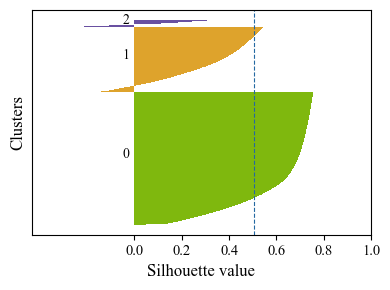

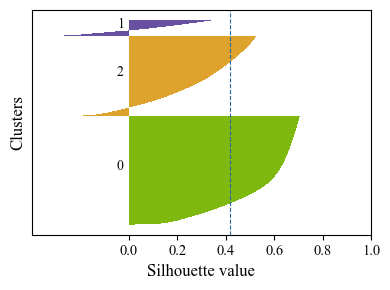

In [5]:
# acc_data = pd.read_excel('../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_主成分结果.xlsx')
all_acc_event = []
for i in range(2):
    acc_event = acc_data[acc_data['v_label'] == i]
    acc_clus = Clustering(
        acc_event[scaler_acc_X.columns.to_list()], calc_best_cluster_flag=False, best_cluster=3)
    print('完成{}聚类'.format(i))
    if acc_clus.calc_best_cluster_flag:
        acc_clus.show_silhouette_clusters()
        print('速度{}轮廓系数：{}'.format(i, acc_clus.silhouette_scores))
        plt.savefig(
            '../GpsFigure/两阶段聚类_New/二阶段加速聚类/speed{}_加速相关指标_聚类数与轮廓系数图.pdf'.format(i))
    acc_event['acc_label'] = acc_clus.best_labels
    all_acc_event.append(acc_event)
    # 绘制加速、减速事件轮廓系数图
    cls_list = list(acc_event[['max_acc_lon', 'acc_label']].groupby(
        'acc_label').mean().sort_values(by='max_acc_lon').index)
    show_silhouette_plot(acc_event, x_cols=['acc_PC1', 'acc_PC2'], y_col='acc_label',
                         num_cls=3, cls_list=cls_list, colors=['#7fb80e', '#dea32c', '#6950a1'])
    plt.savefig(
        '../GpsFigure/两阶段聚类_New/二阶段加速聚类/speed{}_加速相关指标_最优聚类轮廓图.png'.format(i), dpi=1200)
    # 求解聚类中心
    centers = acc_clus.best_kmeans.cluster_centers_
    # x_centers = acc_dr.pca.inverse_transform(centers)
    x_centers = acc_ss.scaler.inverse_transform(centers)
    x_centers = pd.DataFrame(x_centers, columns=acc_X.columns)
    x_centers.to_excel(
        '../GpsData/两阶段聚类_New/二阶段加速聚类/speed{}_加速相关指标_聚类中心点.xlsx'.format(i), index=False)

all_acc_event = pd.concat(all_acc_event, axis=0).reset_index(drop=True)
all_acc_event.to_excel(
    '../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_聚类结果.xlsx', index=False)


### 4 可视化加速度特征二阶段聚类散点图

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('font',family='Times New Roman')

def show_class_result(data:pd.DataFrame, PC_list:list, label:str, pca, num_cls:int, feature_num:int, arrow_text_list:list, xy_labels:list, 
                      cls_list:list, cls_legend:list, cls_colors = ['#bb505d','#7fb80e','#4e72b8'], vector_scale:float = 1):
    """绘制降维后的散点图
    Args:
        data (pd.DataFrame): 需要绘制散点的数据集
        PC_list (list): 散点图x,y轴对应数据data中的列名
        label (str): 散点图分类标签对应数据data中的列名
        pca (_type_): 降维散点图中所使用的pca模型
        num_cls (_int_): 散点分类的个数
        feature_num (int): 降维前的数据原始特征数
        arrow_text_list (list): 原始特征的标签
        xy_labels (list): 绘图坐标轴的标题
        cls_list (list): 分类标签的列表
        cls_legend (list): 绘图中所使用的分类图例
        cls_colors (list, optional): 散点分类所使用的颜色. Defaults to ['#bb505d','#7fb80e','#4e72b8'].
        vector_scale (float, optional): 矢量图缩放比例. Defaults to 1.
    """    
    fig,ax = plt.subplots(figsize=(4,3))

    # 绘制原点的水平线和垂直线
    ax.axhline(y=0, color='#3e4145', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='#3e4145', linestyle='--', linewidth=0.8)
    
    # 可视化分类结果
    # 按照label列分组，将不同的标签对应的数据分别绘制在散点图上，并使用不同颜色表示
    marker_list = ['o', '^', 'x', 'D']
    for i in range(num_cls):
        x = data.loc[data[label] == cls_list[i], PC_list[0]]
        y = data.loc[data[label] == cls_list[i], PC_list[1]]
        plt.scatter(x, y, c=cls_colors[i], label=cls_legend[i], marker=marker_list[i], s=1, alpha=0.5)
    
    # 绘制原始特征的向量线
    features = np.eye(feature_num)
    feature_vectors = pca.transform(features)
    for i, (x, y) in enumerate(feature_vectors[:,[0,1]]):
        plt.arrow(0, 0, x*feature_num*vector_scale, y*feature_num*vector_scale, color='#130c0e',width=0.01, head_width=0.3, 
                head_length=0.3, length_includes_head=True, zorder=100)
        plt.text(x*feature_num*vector_scale, y*feature_num*vector_scale, arrow_text_list[i], fontsize=10, color='k')
    
    # 设置轴标题
    plt.xlabel(xy_labels[0], fontsize=12)
    plt.ylabel(xy_labels[1], fontsize=12)
    

    plt.xlim([-7.5,20])
    plt.ylim([-7.5,15])
    
    # 设置轴刻度属性
    plt.xticks(fontsize=10.5)
    plt.yticks(fontsize=10.5)
    
    # 设置图例
    plt.legend(title='Clusters', fontsize=10.5, loc='upper right')
    plt.tight_layout()
    

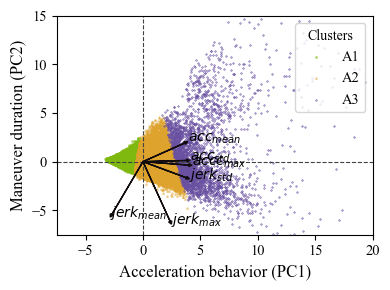

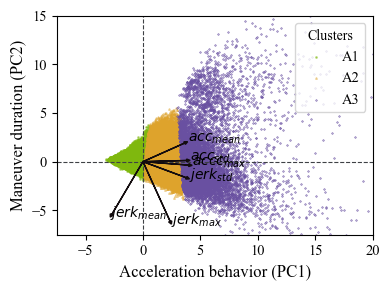

In [13]:
acc_data = pd.read_excel('../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_聚类结果.xlsx')
# 速度聚类模型保存
acc_dr = joblib.load('../GpsData/两阶段聚类_New/二阶段加速聚类/加速相关指标_降维模型.pkl')
for i in range(2):
    event = acc_data[acc_data['v_label'] == i]
    cls_list = list(event[['max_acc_lon', 'acc_label']].groupby('acc_label').mean().sort_values(
        by='max_acc_lon').index)
    show_class_result(event, PC_list=['acc_PC1', 'acc_PC2'], label='acc_label',  pca=acc_dr.pca,
                      num_cls=3, feature_num=6,
                      arrow_text_list=[r'$accc_{max}$', r'$acc_{mean}$', r'$acc_{std}$',
                                       r'$jerk_{max}$', r'$jerk_{mean}$', r'$jerk_{std}$'],
                      xy_labels=[
                          'Acceleration behavior (PC1)', 'Maneuver duration (PC2)'],
                      cls_list=cls_list, cls_legend=['A1', 'A2', 'A3'],
                      cls_colors=['#7fb80e', '#dea32c', '#6950a1'],
                      vector_scale=1.5)
    plt.savefig(
        '../GpsFigure/两阶段聚类_New/二阶段加速聚类/速度{}_加速相关指标_聚类散点图.png'.format(i), dpi=1200)


In [9]:
acc_data[acc_data['v_label']==0].groupby('acc_label').count()

,phone,start_time,end_time,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,...,v_PC1,v_PC2,ss_max_acc_lon,ss_mean_acc_lon,ss_std_acc_lon,ss_max_jerk,ss_mean_jerk,ss_std_jerk,acc_PC1,acc_PC2
acc_label,,,,,,,,,,,,,,,,,,,,,
0,58987,58987,58987,58987,58987,58987,58987,58987,58987,58987,...,58987,58987,58987,58987,58987,58987,58987,58987,58987,58987
1,28687,28687,28687,28687,28687,28687,28687,28687,28687,28687,...,28687,28687,28687,28687,28687,28687,28687,28687,28687,28687
2,3055,3055,3055,3055,3055,3055,3055,3055,3055,3055,...,3055,3055,3055,3055,3055,3055,3055,3055,3055,3055


In [10]:
acc_data[acc_data['v_label']==0].groupby('acc_label').mean()

,phone,duration,min_v,max_v,mean_v,std_v,max_acc_lon,mean_acc_lon,std_acc_lon,min_acc_lon,...,v_PC1,v_PC2,ss_max_acc_lon,ss_mean_acc_lon,ss_std_acc_lon,ss_max_jerk,ss_mean_jerk,ss_std_jerk,acc_PC1,acc_PC2
acc_label,,,,,,,,,,,,,,,,,,,,,
0,1.438750e+10,12.739332,58.307708,67.331083,62.821048,3.066755,0.412220,0.225442,0.110156,0.069329,...,1.859434,0.058077,-0.834535,-0.829826,-0.711437,-0.500061,0.467427,-0.731076,-1.695117,0.040999
1,1.443013e+10,7.471851,55.950995,65.136264,60.527804,3.411597,0.789948,0.398565,0.248207,0.117019,...,1.469895,-0.506739,0.228996,0.056497,0.232805,0.341273,-0.081004,0.312787,0.499972,-0.247022
2,1.443374e+10,4.168576,57.857676,66.365041,62.053711,3.973956,1.498563,0.724626,0.618042,0.222831,...,1.494598,-0.774844,2.224170,1.725803,2.762421,0.832687,-2.505999,2.409638,5.171320,0.855067
